In [21]:
import detection as eddy
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import SymLogNorm
from tqdm import tqdm
import ast

# Set default font size to match LaTeX document
plt.rcParams.update({
    'font.size': 11,       # Default text size
    'axes.titlesize': 10,  # Title size
    'axes.labelsize': 10,  # Axis label size
    'xtick.labelsize': 8, # X-tick label size
    'ytick.labelsize': 8, # Y-tick label size
    'legend.fontsize': 8, # Legend font size
    'figure.titlesize': 12 # Figure title size
})

In [22]:
# Enable/disable computation of different domains
config_parent_domain = True
config_child_domain = True

In [23]:
# Import data
depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(70,75)).sel(X=slice(-22,2))
depth_no_nan = depth
depth = depth.where(depth > 0, np.nan)

df_OW = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Horizontal_Okubo_Weiss.nc')['Okubo_Weiss']
df_OW = df_OW*(1/(10**(-9)))
df_eta = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Horizontal_Eta.nc')['Eta']
df = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Background_var.nc')
df_hor_vel = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Horizontal_hor_vel.nc')['hor_vel']
display(df)

<xarray.Dataset>
Dimensions:    (Z: 216, Zp1: 217, Zu: 216, Zl: 216, X: 765, Y: 628, Xp1: 766,
                Yp1: 629, time: 12, time_midp: 11)
Coordinates: (12/18)
  * Z          (Z) float64 -1.0 -3.5 -7.0 ... -3.904e+03 -3.922e+03 -3.942e+03
  * Zp1        (Zp1) float64 0.0 -2.0 -5.0 ... -3.913e+03 -3.932e+03 -3.951e+03
  * Zu         (Zu) float64 -2.0 -5.0 -9.0 ... -3.913e+03 -3.932e+03 -3.951e+03
  * Zl         (Zl) float64 0.0 -2.0 -5.0 ... -3.894e+03 -3.913e+03 -3.932e+03
  * X          (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.72 11.82 11.92
  * Y          (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    ...         ...
  * time       (time) datetime64[ns] 2017-09-01 2017-10-01 ... 2018-08-01
    YU         (Y, Xp1) float64 ...
    XU         (Y, Xp1) float64 ...
    YV         (Yp1, X) float64 ...
    XV         (Yp1, X) float64 ...
  * time_midp  (time_midp) datetime64[ns] 2017-09-16 ... 2018-07-16T12:00:00
Data variables:
    U          (time, Z, Y, Xp1) float64 ...
    V          (time, Z, Yp1, X) float64 ...
    Temp       (time, Z, Y, X) float64 ...
    S          (time, Z, Y, X) float64 ...
    Eta        (time, Y, X) float64 ...
    MXLDEPTH   (time, Y, X) float64 ...
    SIarea     (time, Y, X) float64 ...
    SIheff     (time, Y, X) float64 ...
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGPyearlong
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []

In [24]:
# Inner domain
domain_center = [[-20,0],[71,74]]
OW_center = df_OW.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1])).sel(Z=-1)
eta_center = df_eta.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1]))

# Outer domain
eta = df_eta.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1))
OW = df_OW.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1)).sel(Z=-1)

In [25]:
# Resample data
eta = eta.resample(time='D').mean(dim='time')
eta_center = eta_center.resample(time='D').mean(dim='time')
OW = OW.resample(time='D').mean(dim='time')
OW_center = OW_center.resample(time='D').mean(dim='time')
hor_vel = df_hor_vel.resample(time='D').mean(dim='time')

# Define time extent
time = ['2018-01-01T00:00:00.000000000','2018-01-10T00:00:00.000000000']
eta = eta.sel(time=slice(time[0],time[1]))
eta_center = eta_center.sel(time=slice(time[0],time[1]))
OW = OW.sel(time=slice(time[0],time[1]))
OW_center = OW_center.sel(time=slice(time[0],time[1]))
hor_vel = hor_vel.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))


eta = eta.where(depth > 0, np.nan)
OW = OW.where(depth > 0, np.nan)
# hor_vel = hor_vel.where(depth > 0, np.nan)


# Eddy centerpoints (Child domain)

In [26]:
# Computes or loads eddy centerpoints
run = config_child_domain
run = False # New method works better
if run:
    eddyLocation = []
    print('###Applying filter###')
    for i in range(len(eta)):
        eddyLocation.append(eddy.eddyDetection(eta_center[i],OW_center[i]))
        print('Processing: ',100*(i+1)/len(eta_center), '%')
    with open("eddyCenterpoints_test.txt",'w') as f:
        for time in range(len(eddyLocation)):
            if time != len(eddyLocation)-1:
                f.write(str(eddyLocation[time])+',')
            else:
                f.write(str(eddyLocation[time]))

else:
    print('###Loading previously saved eddy centerpoints###')
    with open("eddyCenterpoints_test.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)

###Loading previously saved eddy centerpoints###


# Try updated Eddy center detection

In [27]:
import EddyDetectionV2 as testeddy # Works much better

In [28]:
test = testeddy.eddyDetection(eta_center[0],OW_center[0])

In [29]:
display(test[0] == eddyLocation[0][0])
display(test[0],eddyLocation[0][0])

False

[[71.13324712000001, -14.447136549999986],
 [71.13324712000001, -9.397923165000002],
 [71.18737249499999, -13.91529619],
 [71.27832667499999, -5.971855255000001],
 [71.35178564499999, -8.006987669999997],
 [71.35178564499999, -3.6746734799999956],
 [71.38875489499999, -17.184090635],
 [71.463187775, -11.039915429999994],
 [71.51945712999999, -9.484479565000003],
 [71.671460565, -12.905644134999998],
 [71.69066815, -14.714621209999985],
 [71.78742728, -4.4686678699999955],
 [71.88543071000001, -17.419766980000006],
 [71.88543071000001, -8.181655034999997],
 [71.924993885, -10.737527224999994],
 [71.94485499000001, -13.91529619],
 [71.96476979, -13.080454489999997],
 [72.00476254, -10.176089865000002],
 [72.02484154, -11.645367309999994],
 [72.085415495, -13.827028024999999],
 [72.146506485, -1.687209394999996],
 [72.187528595, -16.438886585000006],
 [72.187528595, -8.530200194999997],
 [72.20812984, -16.34663061500001],
 [72.29115009, -13.431002524999997],
 [72.312062055, -14.0036658699

[71.09734426, -8.399611769999996]

In [30]:
# Computes or loads eddy centerpoints
run = config_child_domain
run = True

if run:
    eddyLocation = []
    print('###Applying filter###')
    for i in range(len(eta)):
        eddyLocation.append(testeddy.eddyDetection(eta_center[i],OW_center[i]))
        print('Processing: ',100*(i+1)/len(eta_center), '%')
    with open("eddyCenterpoints_test_v2.txt",'w') as f:
        for time in range(len(eddyLocation)):
            if time != len(eddyLocation)-1:
                f.write(str(eddyLocation[time])+',')
            else:
                f.write(str(eddyLocation[time]))

else:
    print('###Loading previously saved eddy centerpoints###')
    with open("eddyCenterpoints_test_v2.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)

###Applying filter###
Processing:  10.0 %
Processing:  20.0 %
Processing:  30.0 %
Processing:  40.0 %
Processing:  50.0 %
Processing:  60.0 %
Processing:  70.0 %
Processing:  80.0 %
Processing:  90.0 %
Processing:  100.0 %


In [31]:
run = config_parent_domain
run = False

if run:
    eddy_centers = eddyLocation
    T = len(eddyLocation)
    pbar = tqdm(total=T, desc="Running algorythm")
    eddies = xr.full_like(eta,fill_value=0)
    eddies = eddies.rename("EddyDetection")
    for time in range(T):
        # First run per time step
        
        
        eddyDataset = testeddy.newEddyMethod(OW=OW[time],hor_vel=hor_vel[time],eddy_center=eddy_centers[time][0][0],warm=True,eddiesDataset=eddies[time])
        
        for i in range(1,len(eddy_centers[time][0])):
            eddyDataset = testeddy.newEddyMethod(OW=OW[time],hor_vel=hor_vel[time],eddy_center=eddy_centers[time][0][i],warm=True,eddiesDataset=eddyDataset)
            
        for i in range(0,len(eddy_centers[time][1])):
            eddyDataset = testeddy.newEddyMethod(OW=OW[time],hor_vel=hor_vel[time],eddy_center=eddy_centers[time][1][i],cold=True,eddiesDataset=eddyDataset)
        #eddyDataset = testeddy.outer_eddy_region(hor_vel=hor_vel[time],eddiesDataset=eddyDataset)
        eddyDataset = eddyDataset.where(eddyDataset != 0, np.nan)
        pbar.update(1)
        eddies[time] = eddyDataset
    eddies.to_netcdf('/nird/projects/NS9608K/MSc_EK/Data/EddiesTest.nc')
else:
    eddies = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/EddiesTest.nc')
    eddies = eddies['EddyDetection']

In [32]:
display(eddies)

<xarray.DataArray 'EddyDetection' (time: 31, Y: 231, X: 510)>
[3652110 values with dtype=float64]
Coordinates:
  * X        (X) float64 -21.98 -21.93 -21.87 -21.82 ... 1.822 1.879 1.936 1.994
  * Y        (Y) float64 70.01 70.03 70.04 70.06 ... 74.89 74.92 74.95 74.99
    XC       (Y, X) float64 ...
    YC       (Y, X) float64 ...
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-31
Attributes:
    long_name:      free-surface_r-anomaly
    units:          m
    standard_name:  sea_surface_height_above_geoid
    _coordinates:   XC YC iter

Generating Frames: 21it [00:14,  1.43it/s]                        


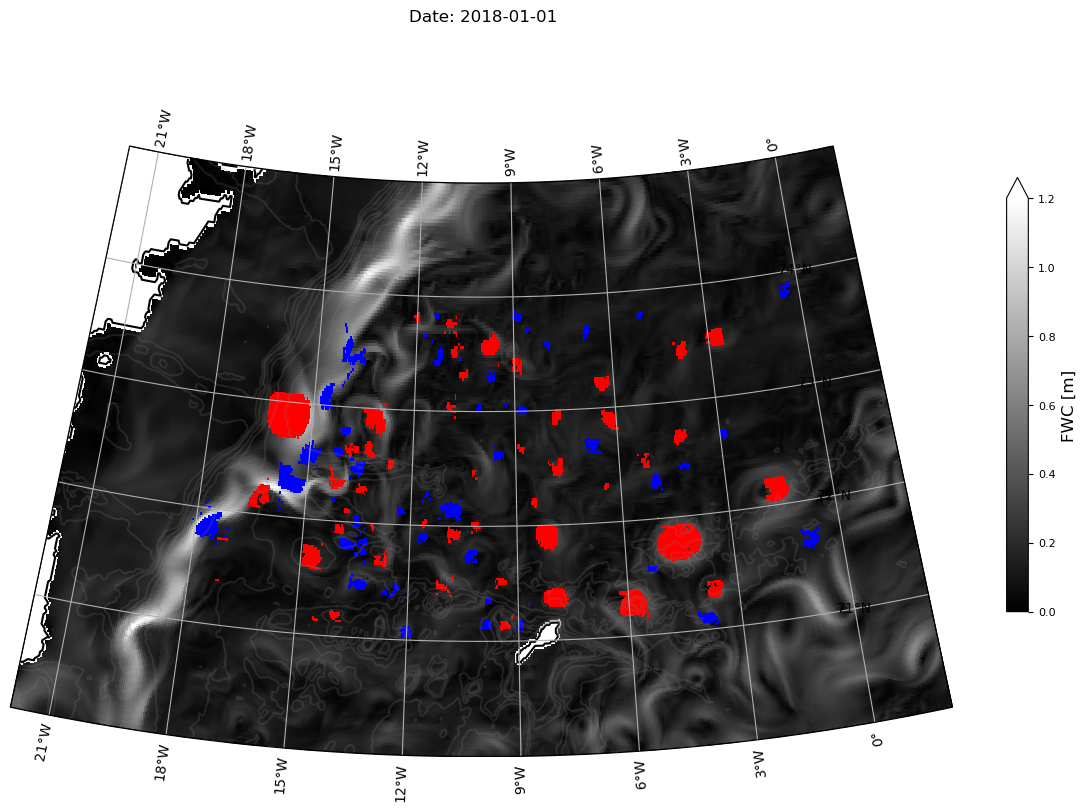

In [33]:
from matplotlib.animation import FuncAnimation, FFMpegFileWriter

eddies = eddies[0:len(hor_vel)]

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, axs = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-22+10, 2+10, 70, 75]

# Define the custom colormap
colors = ['red', 'blue', 'yellow', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the data using pcolormesh without normalization
pcm1 = axs.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[0],vmin=0,vmax=1.2,cmap='binary_r',transform=ccrs.PlateCarree())
axs.pcolormesh(eddies.X, eddies.Y, eddies[0], cmap=cmap,norm=norm, transform=ccrs.PlateCarree())
# Add land contour
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm1, ax=axs, shrink=0.6, extend='max')
cbar.set_label('FWC [m]', fontsize=12)


# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
axs.add_patch(patch)


# Set the boundary using the transformed path
axs.set_boundary(patch.get_path(), transform=axs.transData)

# Add gridlines and labels
gl = axs.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}


T = len(eddies.time)
pbar = tqdm(total=T, desc="Generating Frames")

def update_plot(frame):
    axs.clear()
    fig.suptitle(f'Date: {str(eddies.time.values[frame])[0:10]}')
    axs.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[frame],vmin=0,vmax=1.2,cmap='binary_r',transform=ccrs.PlateCarree())
    axs.pcolormesh(eddies.X, eddies.Y, eddies[frame], cmap=cmap,norm=norm, transform=ccrs.PlateCarree())
    
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())

    
    # Create a custom path for the extent in PlateCarree projection
    num_points = 100
    bottom_lons = np.linspace(extent[0], extent[1], num_points)
    top_lons = np.linspace(extent[1], extent[0], num_points)
    bottom_lats = np.full_like(bottom_lons, extent[2])
    top_lats = np.full_like(top_lons, extent[3])

    # Combine the vertices
    verts = np.vstack([
        np.column_stack([bottom_lons, bottom_lats]),
        np.column_stack([top_lons, top_lats])
    ])

    # Transform the vertices to the NorthPolarStereo projection
    proj = ccrs.NorthPolarStereo()
    verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
    verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

    # Create the path
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
    path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
    patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
    axs.add_patch(patch)


    # Set the boundary using the transformed path
    axs.set_boundary(patch.get_path(), transform=axs.transData)

    # Add gridlines and labels
    gl = axs.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}


    pbar.update(1)

ani = FuncAnimation(fig, update_plot, frames=T, interval=1000)
ani.save(r'/nird/home/ekv036/MSc/Animations/Eddies.gif', writer='pillow', progress_callback=lambda i, n: pbar.update(1))
pbar.close()

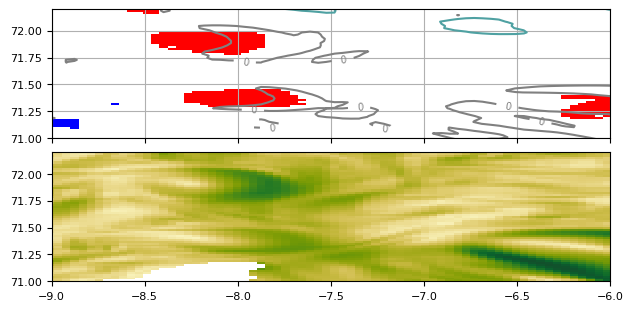

In [34]:
fig, (ax,ax2) = plt.subplots(2,1,
    figsize=(6.2217,3), sharey=True,sharex=True, layout='constrained'
)

# Define the custom colormap
colors = ['red', 'blue', 'yellow', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

ax.pcolormesh(eddies.X,eddies.Y,eddies[0],cmap=cmap,norm=norm)
ax.set_xlim(-9,-6)
ax.set_ylim(71,72.2)

ax.contour(eta.X,eta.Y,eta[0],cmap=cmo.deep)
cntr = ax.contour(hor_vel.X,hor_vel.Y,hor_vel[0],colors='grey')
ax.clabel(cntr, fmt="%2.0f", use_clabeltext=True,fontsize=7)

ax.grid()

ax2.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[0],cmap=cmo.speed,vmin=0,vmax=0.5)

fig.savefig(r'/nird/home/ekv036/MSc/Fig/EddyTestCalib',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

Mask values (True indicates inside the outermost contour):
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Number of True values in mask: 2620


/tmp/ipykernel_4135836/994733639.py:33: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contours.collections:


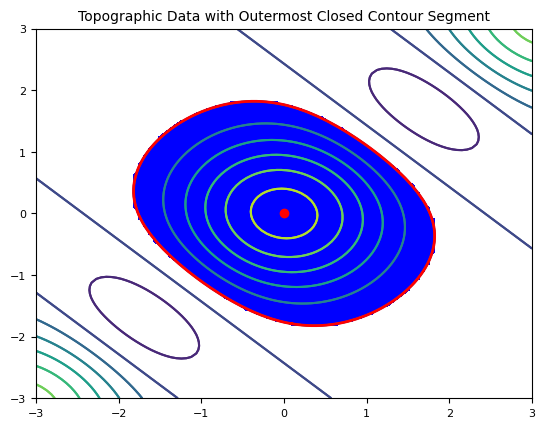

Outermost closed contour segment bounding box: min_x=-1.8208310453703545, min_y=-1.8208310453703545, max_x=1.8208310453703542, max_y=1.8208310453703542


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# Step 1: Create the Synthetic Data
def create_topographic_data(size):
    x = np.linspace(-3, 3, size)
    y = np.linspace(-3, 3, size)
    X, Y = np.meshgrid(x, y)
    
    # Create a peak at the center
    center_peak = np.exp(-0.5 * (X**2 + Y**2))
    
    # Create a valley around the center peak
    valley = -0.5 * np.exp(-0.5 * ((X-2)**2 + (Y-2)**2)) - 0.5 * np.exp(-0.5 * ((X+2)**2 + (Y+2)**2))
    
    # Create peaks at the edges
    edge_peaks = np.exp(-0.5 * ((X-3)**2 + (Y-3)**2)) + np.exp(-0.5 * ((X+3)**2 + (Y+3)**2))
    
    # Combine all features
    data = center_peak + valley + edge_peaks
    return X, Y, data

size = 100
X, Y, data = create_topographic_data(size)

# Step 2: Generate Contours
contours = plt.contour(X, Y, data)

# Step 3: Collect all X and Y points of the paths of all contours
all_contour_points = []

for collection in contours.collections:
    for path in collection.get_paths():
        # Collect the vertices of the path
        vertices = path.vertices
        all_contour_points.append(vertices)

# Step 4: Identify the Center Point
center_point = (0, 0)

# Step 5: Process Contour Paths to Handle Jumps
def process_contour_path(vertices, jump_threshold=0.1):
    segments = []
    current_segment = [vertices[0]]
    
    for i in range(1, len(vertices)):
        if np.linalg.norm(vertices[i] - vertices[i-1]) > jump_threshold:
            segments.append(np.array(current_segment))
            current_segment = [vertices[i]]
        else:
            current_segment.append(vertices[i])
    
    if current_segment:
        segments.append(np.array(current_segment))
    
    return segments

processed_contour_segments = []
for vertices in all_contour_points:
    segments = process_contour_path(vertices)
    processed_contour_segments.extend(segments)

# Step 6: Find the Outermost Closed Contour Segment
outermost_contour = None
max_area = 0

def is_closed_contour(vertices, tol=1e-5):
    distance = np.linalg.norm(vertices[0] - vertices[-1])
    return distance < tol

for vertices in processed_contour_segments:
    # Create a Path object from the vertices
    path_obj = Path(vertices)
    
    # Check if the contour segment is closed
    if is_closed_contour(vertices, tol=1e-2):  # Adjust the tolerance value as needed
        # Check if the center point is inside the contour segment
        if path_obj.contains_point(center_point):
            # Calculate the area of the contour segment using the shoelace formula
            x = vertices[:, 0]
            y = vertices[:, 1]
            area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
                        # Update the outermost contour if this one has a larger area
            if area > max_area:
                max_area = area
                outermost_contour = vertices



# Print the bounding box of the outermost closed contour segment
if outermost_contour is not None:

    outermost_path = Path(outermost_contour)
    mask = np.zeros(X.shape, dtype=bool)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = (X[i, j], Y[i, j])
            if outermost_path.contains_point(point):
                mask[i, j] = True
    
    print("Mask values (True indicates inside the outermost contour):")
    print(mask)
    print(f"Number of True values in mask: {np.sum(mask)}")
    
    min_x, min_y = np.min(outermost_contour, axis=0)
    max_x, max_y = np.max(outermost_contour, axis=0)

    # Step 7: Plot the Data and the Outermost Closed Contour Segment
    plt.contour(X, Y, data)
    if outermost_contour is not None:
        plt.plot(outermost_contour[:, 0], outermost_contour[:, 1], 'r-', linewidth=2)
        plt.contourf(X, Y, mask, colors=['white', 'blue'])
    plt.scatter(*center_point, color='red')  # Mark the center point
    plt.title("Topographic Data with Outermost Closed Contour Segment")
    plt.show()

    print(f"Outermost closed contour segment bounding box: min_x={min_x}, min_y={min_y}, max_x={max_x}, max_y={max_y}")
else:
    print("No closed contour segments found containing the center point.")

# Test new inner eddy method

In [36]:
display(eddyLocation[0][0][0])
display(eta[0])

[71.13324712000001, -14.447136549999986]

<xarray.DataArray 'Eta' (Y: 231, X: 510)>
array([[-0.08771137, -0.10097562, -0.11570576, ..., -0.11712228,
        -0.11282054, -0.10796896],
       [-0.08750664, -0.10056364, -0.11535378, ..., -0.11857502,
        -0.11454787, -0.10998559],
       [-0.08698117, -0.09956231, -0.11433678, ..., -0.12012125,
        -0.11628922, -0.11200542],
       ...,
       [        nan,         nan,         nan, ..., -0.19963544,
        -0.19735152, -0.19482848],
       [        nan,         nan,         nan, ..., -0.19679575,
        -0.19457979, -0.19223616],
       [        nan,         nan,         nan, ..., -0.19373574,
        -0.19176141, -0.18977277]])
Coordinates:
  * X        (X) float64 -21.98 -21.93 -21.87 -21.82 ... 1.822 1.879 1.936 1.994
  * Y        (Y) float64 70.01 70.03 70.04 70.06 ... 74.89 74.92 74.95 74.99
    XC       (Y, X) float64 -21.98 -21.93 -21.87 -21.82 ... 1.879 1.936 1.994
    YC       (Y, X) float64 70.01 70.01 70.01 70.01 ... 74.99 74.99 74.99 74.99
    time     datetime64[ns] 2018-01-01
Attributes:
    long_name:      free-surface_r-anomaly
    units:          m
    standard_name:  sea_surface_height_above_geoid
    _coordinates:   XC YC iter

In [37]:
run = True
if run:
    eddies = xr.full_like(eta,fill_value=0)
    eddies = eddies.rename("EddyDetection")
    T = len(eddyLocation)
    pbar = tqdm(total=T, desc="Running algorythm")
    for time in range(len(eddyLocation)):
        eddies[time] = testeddy.inner_eddy_region_v3(eddyLocation[time][0],eta=eta[time],warm=True,cold=False,test_calib=False,eddiesData=eddies[time])
        eddies[time] = testeddy.inner_eddy_region_v3(eddyLocation[time][1],eta=eta[time],warm=False,cold=True,test_calib=False,eddiesData=eddies[time])
        pbar.update(1)
    eddies = eddies.where(eddies != 0, np.nan)
    eddies.to_netcdf('/nird/projects/NS9608K/MSc_EK/Data/EddiesTest_v3.nc')
else:
    eddies = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/EddiesTest_v3.nc')
    eddies = eddies['EddyDetection']

Running algorythm: 100%|██████████| 10/10 [01:09<00:00,  6.50s/it]

In [38]:
eddies = eddies.where(eddies != 0, np.nan)

Running algorythm: 100%|██████████| 10/10 [01:10<00:00,  7.00s/it]
Generating Frames: 21it [00:16,  1.29it/s]


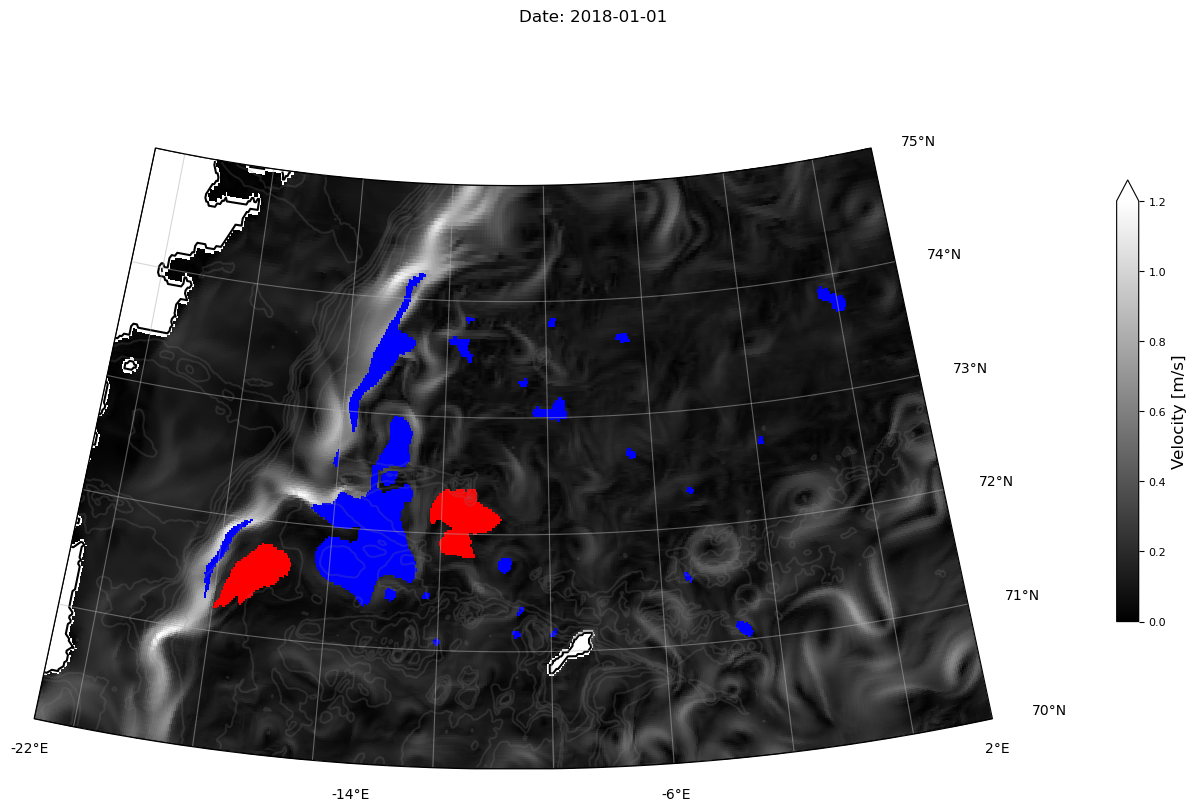

In [39]:
from matplotlib.animation import FuncAnimation, FFMpegFileWriter

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, axs = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-22+10, 2+10, 70, 75]

# Define the custom colormap
colors = ['red', 'blue', 'yellow', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the data using pcolormesh without normalization
pcm1 = axs.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[0],vmin=0,vmax=1.2,cmap='binary_r',transform=ccrs.PlateCarree())
axs.pcolormesh(eddies.X, eddies.Y, eddies[0], cmap=cmap,norm=norm, transform=ccrs.PlateCarree())
# Add land contour
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm1, ax=axs, shrink=0.6, extend='max')
cbar.set_label('Velocity [m/s]', fontsize=12)


# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
axs.add_patch(patch)


# Set the boundary using the transformed path
axs.set_boundary(patch.get_path(), transform=axs.transData)

# Add gridlines without labels
gl = axs.gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 8)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
    axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')


T = len(eddies.time)
pbar = tqdm(total=T, desc="Generating Frames")

def update_plot(frame):
    axs.clear()
    fig.suptitle(f'Date: {str(eddies.time.values[frame])[0:10]}')
    axs.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[frame],vmin=0,vmax=1.2,cmap='binary_r',transform=ccrs.PlateCarree())
    axs.pcolormesh(eddies.X, eddies.Y, eddies[frame], cmap=cmap,norm=norm, transform=ccrs.PlateCarree())
    
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())

    
    # Create a custom path for the extent in PlateCarree projection
    num_points = 100
    bottom_lons = np.linspace(extent[0], extent[1], num_points)
    top_lons = np.linspace(extent[1], extent[0], num_points)
    bottom_lats = np.full_like(bottom_lons, extent[2])
    top_lats = np.full_like(top_lons, extent[3])

    # Combine the vertices
    verts = np.vstack([
        np.column_stack([bottom_lons, bottom_lats]),
        np.column_stack([top_lons, top_lats])
    ])

    # Transform the vertices to the NorthPolarStereo projection
    proj = ccrs.NorthPolarStereo()
    verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
    verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

    # Create the path
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
    path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
    patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
    axs.add_patch(patch)


    # Set the boundary using the transformed path
    axs.set_boundary(patch.get_path(), transform=axs.transData)

    # Add gridlines without labels
    gl = axs.gridlines(draw_labels=False,alpha=0.5)

    # Manually add the labels for the bottom and right sides
    xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 8)  # Adjust the range and step as needed
    yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

    # Add bottom labels
    for xtick in xticks:
        axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
                fontsize=10, ha='center', va='top')

    # Add right labels
    for ytick in yticks:
        axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
                fontsize=10, ha='left', va='center')


    pbar.update(1)

ani = FuncAnimation(fig, update_plot, frames=T, interval=1000)
ani.save(r'/nird/home/ekv036/MSc/Animations/Eddies_v3.gif', writer='pillow', progress_callback=lambda i, n: pbar.update(1))
pbar.close()

In [40]:
display(eddyLocation[7][1])

[[71.07944607, -11.212786989999993],
 [71.09734426, -8.834421810000002],
 [71.115277835, -7.040532414999996],
 [71.115277835, -3.438140434999995],
 [71.16929411499999, -18.280602145],
 [71.16929411499999, -11.775287739999992],
 [71.26005971999999, -17.514437310000005],
 [71.38875489499999, -9.007991005000004],
 [71.44451680499998, -13.343242894999996],
 [71.463187775, -4.974819849999996],
 [71.576119545, -8.006987669999997],
 [71.65230002, -3.5802336299999955],
 [71.72922620499999, -17.419766980000006],
 [71.76797778, -9.354633240000002],
 [71.80692653999999, -13.871149594999999],
 [71.82647603499998, -11.256016879999994],
 [71.90518596, -14.313800109999987],
 [71.90518596, -9.873658340000002],
 [71.9847388, -12.165578744999994],
 [72.085415495, -6.061600810000002],
 [72.12608444, -7.084704384999996],
 [72.187528595, -11.039915429999994],
 [72.20812984, -0.41150219999999915],
 [72.228792005, -12.165578744999994],
 [72.228792005, -7.656757679999997],
 [72.24951569, -5.47569651],
 [72.31

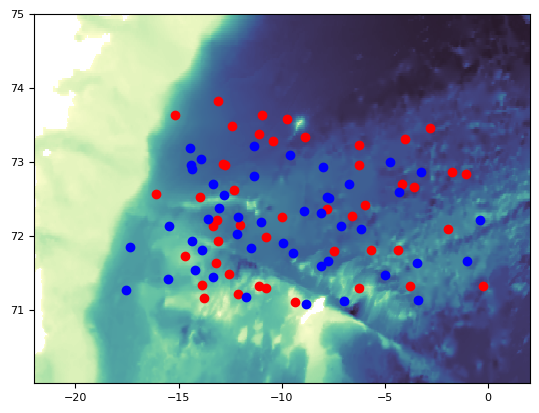

In [41]:
fig, ax = plt.subplots()
ax.pcolormesh(depth.X,depth.Y,depth,cmap=cmo.deep)
for data in zip(eddyLocation[6][0],eddyLocation[6][1]):
    ax.scatter(data[0][1],data[0][0],c='r')
    ax.scatter(data[1][1],data[1][0],c='b')


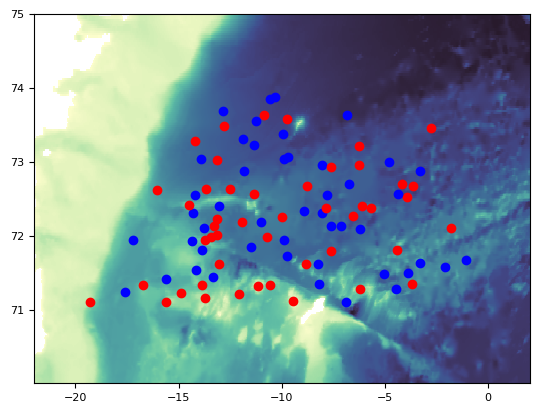

In [42]:
fig, ax = plt.subplots()
ax.pcolormesh(depth.X,depth.Y,depth,cmap=cmo.deep)
for data in zip(eddyLocation[5][0],eddyLocation[5][1]):
    ax.scatter(data[0][1],data[0][0],c='r')
    ax.scatter(data[1][1],data[1][0],c='b')